In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
from general_utils import rank_and_bin
from plot_utils import plot_and_compare_results

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

https://www.nature.com/articles/nature21065

"All liver zonation profiles previously described were monotonically increasing or decreasing porto–centrally. Our high spatial resolution enabled identification of a new class of non-monotonic zonation profiles that peak at intermediate lobule layers (Figs. 3c, 4a, Extended Data Figs 5, 10). Although there was no significant gene ontology annotation associated with these genes, they included key liver genes such as Hamp and Hamp2 that encode hepcidin, a secreted liver hormone that regulates systemic iron levels (Fig. 4a). Additional non-monotonic genes included Igfbp2, Mup3 and Cyp8b1 (Fig. 3c, Extended Data Figs 5, 10). The non-monotonic expression of these genes could not be explained by the previously identified non-monotonic pattern of liver polyploidy25 (Extended Data Fig. 10e, Methods)."

### Load the ground-truth and evaluate the methods

In [3]:
logger.setLevel(logging.DEBUG)
from liver_info import load_processsed_hepatocyte_data, load_zonation_result
dat_dir = "/share/PI/sabatti/sc_data/liver2k"
zone_vals = load_zonation_result(dat_dir, just_vals=True)
main_dir = os.path.join(dat_dir, "analysis_on_data_original")
x_k, mtx, obs_df, var_df = load_processsed_hepatocyte_data(main_dir, center=False, scale=False)

[feat_viz INFO] Data directory: /share/PI/sabatti/sc_data/liver2k/analysis_on_data_original/data
[feat_viz INFO] Loaded data: x (1415, 6) and y (1415, 8883)


### Load the results prescribed method (ran below)

In [4]:
from io_utils import load_all_pipeline_results
from spline_utils import setup_basis, spline_fit
from general_utils import rank_and_bin, norm_mtx
from io_utils import save_data_to_file
from main_methods import refit_curves

RDIR = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_050719"
method = 'graph'
mtype = 'vanilla'
ddir = os.path.join(RDIR, 'hepa_data', 'results', '{}_{}'.format(method, mtype))
assert os.path.exists(ddir), '{} does not exist'.format(ddir)
fns = {
    'result': os.path.join(ddir, 'method_result.pkl'),
    'coeff_mtx': os.path.join(ddir, 'coeff_matrix.npy'),
    'embed_dict': os.path.join(ddir, 'embed_dict.pkl'),
    'gene_clust_df': os.path.join(ddir, 'gene_clust_df.csv')
}

In [5]:
pipe_res, all_lams = load_all_pipeline_results(RDIR)
result =  pipe_res['graph_vanilla']
lam = result['lam_update']

In [6]:
# get the variable group ids
mtx = norm_mtx(mtx)
base_args = setup_basis(lam, n_knots=5)
print(base_args)
p_fun, c_mtx = spline_fit(lam, mtx, base_args)
print(c_mtx.shape)
save_data_to_file(c_mtx, fns['coeff_mtx'], 'npy')

cr(x, knots=(-0.011, 0.013, 0.038, 0.062, 0.087))
Fitted 1000 parameters
Fitted 2000 parameters
Fitted 3000 parameters
Fitted 4000 parameters
Fitted 5000 parameters
Fitted 6000 parameters
Fitted 7000 parameters
Fitted 8000 parameters


[feat_viz DEBUG] Data (shape (8883, 8)) saved as: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_050719/hepa_data/results/graph_vanilla/coeff_matrix.npy


(8883, 8)


In [7]:
x_vals, fit_mtx = refit_curves(c_mtx, base_args, lam)

[feat_viz INFO] Fitted points stored in (50, 8883)


## Select Variable Genes

(884, 5)
Retaining genes: 884


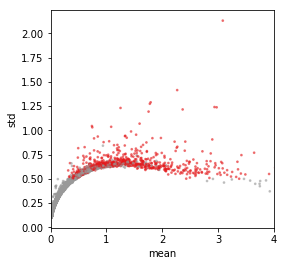

In [8]:
# use the cutoff to select genes to further cluster
cut_off = 0.5
var_df = var_df.reset_index(drop=True)
sel = var_df['std'] > cut_off
use_df = var_df.loc[sel]
use_df = use_df.loc[use_df.index.isin(result['rejections'])]
print(use_df.shape)
sel_or_not = (var_df.index.isin(use_df.index))
print('Retaining genes: {}'.format(np.sum(sel_or_not)))
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(var_df['mean'], var_df['std'], c=sel_or_not*-1, 
           s=3, cmap='Set1', alpha =0.5)
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.set_xlim(0, 4)
plt.show()

# Run the gene clustering pipeline

In [9]:
# our pipeline
import umap
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans

uobj = umap.UMAP(random_state=10101)
u_mtx = c_mtx[use_df.index, :]
print("input dimension: {}".format(u_mtx.shape))
embedding = uobj.fit_transform(u_mtx)

input dimension: (884, 8)


In [10]:
from main_methods import graph_spectrum, graph_clustering
from plot_utils import plot_multiple_scatter_discrete
evals, evecs = graph_spectrum(uobj.graph_)
optimal_kvals = np.argsort(np.diff(evals))[::-1] + 1
print(optimal_kvals)

[13  5  2  4  1  8 16  7  6 17  9 11 10 18 15  3 14 19 12]


orig_idx  n_cells      mean       std   npc  k_3  k_4  \
gene_ids                                                                       
0610007C21Rik;Apr3            0      770  0.487967  0.527124   770    0    1   
0610010K14Rik;Rnasek         10     1162  1.082575  0.665320  1162    0    2   
0610011F06Rik                12     1223  1.223668  0.643116  1223    1    2   
1100001G20Rik                24     1379  2.721297  0.783406  1379    2    0   
1110034A24Rik;Rpl36al        47     1173  1.071354  0.621363  1173    1    2   

                       k_5  k_6  k_13    umap 1    umap 2  
gene_ids                                                   
0610007C21Rik;Apr3       0    0    12 -0.027760 -2.086087  
0610010K14Rik;Rnasek     1    2     4 -4.520930 -1.340668  
0610011F06Rik            1    2     0 -3.056387 -0.003280  
1100001G20Rik            4    3     5  4.557839  0.179997  
1110034A24Rik;Rpl36al    2    1     1  0.298861  0.918414

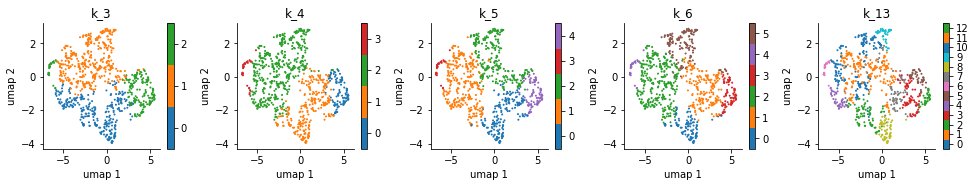

In [11]:
k_vals = [3, 4, 5, 6, 13]
kids = ['k_{}'.format(k) for k in k_vals] 
clust_df = graph_clustering(evecs, k_vals)
# merge
mdf = use_df.reset_index().rename(columns={'index': 'orig_idx'})
mdf = mdf.join(clust_df)
mdf = mdf.set_index('gene_ids')
mdf['umap 1'] = embedding[:, 0]
mdf['umap 2'] = embedding[:, 1]
int_df = mdf
display(int_df.head())
plot_multiple_scatter_discrete(int_df[['umap 1', 'umap 2']], int_df[kids])

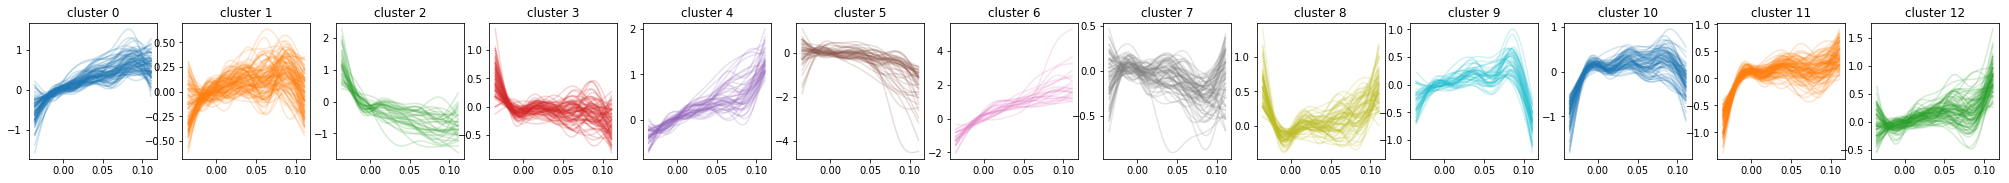

gene_ids
Hamp      5
Hamp2     5
Igfbp2    5
Mup3      3
Cyp8b1    1
Name: k_13, dtype: int32

In [12]:
from plot_utils import plot_multi_curves, get_sim_color_map
def plot_cluster_curves(ddf, col, dat):
    cids = np.unique(ddf[col])
    lut = get_sim_color_map(ddf[col], palette='tab10')
    figsize = (2.9*len(cids)-0.2*(len(cids)-1),2.5)
    fig, axes = plt.subplots(1, len(cids), figsize=figsize)
    for i, cid in enumerate(cids):
        sel = ddf[col] == cid
        idx = ddf.loc[sel][dat['idx']]
        mat = dat['mtx'][:, idx]
        x = dat['x']
        ax = axes[i]
        plot_multi_curves(ax, x, mat, alpha=0.2, color=lut[cid])
        ax.set_title('cluster {}'.format(cid))
    plt.show()
use_k = 'k_13'
dat_dict = {'x': x_vals, 'mtx': fit_mtx, 'idx': 'orig_idx'}
plot_cluster_curves(int_df, use_k, dat_dict)
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
int_df.loc[report_genes][use_k]

In [19]:
from collections import Counter
from io_utils import save_data_to_file
fdir = '/scratch/PI/sabatti/spatial_subplots/'
def save_clusters_to_dir(use_k):
    cdir = fdir + 'hepa_gene_clusters_ours_{}/'.format(use_k)
    os.makedirs(cdir, exist_ok=True)
    # save cluster genes to folder    
    cids = np.unique(clust_df[use_k])
    print(Counter(clust_df[use_k]))
    for cid in cids:
        gdf = int_df.loc[int_df[use_k]==cid].copy()
        gdf['gene_ids'] =  gdf.index
        glist = gdf['gene_ids']
        print('c{} : {}'.format(cid, len(glist)))
        fn = os.path.join(cdir, 'c_{}.csv'.format(cid))
        save_data_to_file(gdf, fn, 'csv')
        print('saved: {}'.format(fn))

def print_gene_cluster(int_df, use_k, cid):
    sdf = int_df.loc[int_df[use_k] == cid]
    print(sdf.shape)
    for g in sdf.index:
        print(g)
        
save_clusters_to_dir('k_13')

[feat_viz DEBUG] Data (shape (95, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_0.csv
[feat_viz DEBUG] Data (shape (108, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_1.csv
[feat_viz DEBUG] Data (shape (37, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_2.csv
[feat_viz DEBUG] Data (shape (84, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_3.csv
[feat_viz DEBUG] Data (shape (48, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_4.csv
[feat_viz DEBUG] Data (shape (46, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_5.csv
[feat_viz DEBUG] Data (shape (23, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_6.csv
[feat_viz DEBUG] Data (shape (69, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_7.csv
[feat_viz DEBUG

Counter({1: 108, 11: 101, 0: 95, 12: 85, 3: 84, 10: 76, 7: 69, 8: 68, 4: 48, 5: 46, 9: 44, 2: 37, 6: 23})
c0 : 95
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_0.csv
c1 : 108
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_1.csv
c2 : 37
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_2.csv
c3 : 84
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_3.csv
c4 : 48
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_4.csv
c5 : 46
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_5.csv
c6 : 23
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_6.csv
c7 : 69
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_7.csv
c8 : 68
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_8.csv
c9 : 44
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_9.csv
c10

[feat_viz DEBUG] Data (shape (85, 13)) saved as: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_12.csv


saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_11.csv
c12 : 85
saved: /scratch/PI/sabatti/spatial_subplots/hepa_gene_clusters_ours_k_13/c_12.csv


In [104]:
# print_gene_cluster(int_df, use_k, 1) # has metabolic process
# print_gene_cluster(int_df, use_k, 3) # has metabolic process
# print_gene_cluster(int_df, use_k, 2) # has catabolic process
# print_gene_cluster(int_df, use_k, 0) # has metabolic process and biosynthetic process
# print_gene_cluster(int_df, use_k, 4) # ONLY has NADPH oxidation
# print_gene_cluster(int_df, use_k, 5) # has oxoacid metabolic process
# print_gene_cluster(int_df, use_k, 6) # has metabolic process
# print_gene_cluster(int_df, use_k, 7) # has metabolic process
# print_gene_cluster(int_df, use_k, 8) # has epoxide metabolic process
print_gene_cluster(int_df, use_k, 12) # has fatty acid beta-oxidation

(85, 12)
0610007C21Rik;Apr3
1600002H07Rik
AI462493
AK087942;Oaz1;Mir1982
Abcd3
Acox2
Adk
Afg3l1
Ak3
Ankrd11
Atpase6
BC004004
C2cd2
Cct2
Ces3a
Cmah;CMAH
Cml1
Cnpy2
Cntf;Zfp91
Cpt2
Csde1;mKIAA0885
Ctage5
Ctsh
Cyp2d11;Cyp2d10
Decr2
Deptor;AK171902
Dhdh
Dynlrb1
Fam162a
Fam32a
Gcdh
Gclc
Glyat
Gnb2l1;Snord96a
Golga4
Grn
Hgd
Hint1
Hsd17b2
Hyal1;Nat6;Hyal3
Hyi
Idh1
Ifnar2
Inhbc
Itm2b
Lrp1
Lrrc58
Mdh2
Mgst1
Mir703
Mrpl20
Mttp
Ndufa4
Ndufc2
Nmt1
Pabpc1;Pabpc2
Pah
Paqr9
Pdia4;Mir704
Prdx6
Psma7
Psmd12
Psmd9
Ptprd
Rdx;BC147413
Rps24
Scaf11
Scap
Sdhb
Sec62
Sephs2
Setd1a;Hsd3b7
Slc22a18
Slc25a3
Slc39a4
Spp2
Tmem14c
Tmem160
Tmem176a
Tubb2a
Ugt1a1;Ugt1a2;Ugt1a5;Ugt1a6;Ugt1a6a;Ugt1a6b;Ugt1a7c;Ugt1a9;Ugt1a10
Ugt3a2
Usmg5
Wdtc1
Wrnip1;WHIP


In [35]:
# sel_idx = pipe_res['graph_vanilla']['rejections']
# use_df = var_df.loc[sel_idx]
print(use_df.shape)
use_df.head()

(1483, 5)


gene_ids  n_cells      mean       std   npc
0          0610007C21Rik;Apr3      770  0.487967  0.527124   770
10       0610010K14Rik;Rnasek     1162  1.082575  0.665320  1162
12              0610011F06Rik     1223  1.223668  0.643116  1223
23  100039707;Gm2382;AK149842      469  0.241706  0.393227   469
24              1100001G20Rik     1379  2.721297  0.783406  1379

In [35]:
# sel_idx = pipe_res['graph_vanilla']['rejections']
# use_df = var_df.loc[sel_idx]
print(use_df.shape)
use_df.head()

(1483, 5)


gene_ids  n_cells      mean       std   npc
0          0610007C21Rik;Apr3      770  0.487967  0.527124   770
10       0610010K14Rik;Rnasek     1162  1.082575  0.665320  1162
12              0610011F06Rik     1223  1.223668  0.643116  1223
23  100039707;Gm2382;AK149842      469  0.241706  0.393227   469
24              1100001G20Rik     1379  2.721297  0.783406  1379

## Cluster 5



In [92]:
print_gene_cluster(int_df, use_k, 5)

(46, 12)
1100001G20Rik
Apom
Arg1
Asl
Ass1
Atf5
Atp2a2
C2
Ccbl1
Ccbl2
Ces1b
Ces1e
Ces3b
Cps1
Cth
Dak
Ehhadh
Fga
Ftcd
Ganab;mKIAA0088
Gm2a
Gnmt
H2-D1;H2-B2
Hamp
Hamp2
Hdmcp;Slc25a47
Herpud1
Hgfac
Igf1
Igfbp2
Khk
Mup21
Orm1
Pck1
Pgk1
Pigr
Scd1
Sdhd
Selenbp2
Serpina1e
Serpind1
Serpinf1
Slc7a2
St3gal5
Tat
Uqcr10


## Cluster 11

18 out of 101 genes  
Example: peptide metabolic process

In [91]:
print_gene_cluster(int_df, use_k, 11)

(101, 12)
AK172428;Ubxn1
Abhd14b
Acaa1a
Acads
Actb
Aes
Afmid;Clast2;Syngr2
Ak2
Apoc1
Arf1
Arpp19
Atf4
Atp5d
Atp5e
Bdh1
Cdo1
Ces1c
Chchd2
Cib1
Clmn;mKIAA1188
Cox17
Cox4i1
Cox6a1
Cyb5r3
D17Wsu92e
D8Ertd738e
Ddt
Dynll2;Gdi-1
Eef1g
Eef2
Eif3d
Eif4g1
Epn1
Fam108a
Fetub
Fkbp5
Fth1
Gck
Gclm
Gm15427;Rpl18a
Gne
Gpt2
Grb7
H1f0;Icam1
Haao
Hadh
Hint2
Hsp90ab1
Hspe1
Kif5b
Klf13
Klf9
Krt18
Larp1
Lpin1
Ltbr
Mir682
Ndufb3
Ndufb7
Ndufb9
Nfe2l1
Nfic
Nfix
Onecut2
Optn
Ormdl3
Pemt
Ppp6r1
Prdx5
Prpf19
Psmb1
Psmc1
Psmd4
Ptms
Rnaset2a;Rnaset2b;Gm1604b
Rnf10;RIE2
Rpl13
Rpl13a;Rpl13a-ps1;Snord34
Rpl26
Rpl8
Rplp0
Rplp2
Rps10
Rps15
Rps18
Rps19
Rps21
Rps27l
Rps9
Rpsa
Sec14l2
Selenbp1
St13
Tceb2
Tef
Timm10
Tmem134
Tnfaip8l1
Tomm6
Vcp
Ybx1


## Cluster 9

11 out of 44 genes  
Example: carboxylic acid metabolic process

In [89]:
print_gene_cluster(int_df, use_k, 9)

(44, 12)
8430408G22Rik
Aass
Acaa2
Alas2
Aldoa
Amfr
Arpc2
Ces1d
Cflar
Clptm1
Cyp3a11
Cyp4f14
Dera
Dnaja1;Mir207
Fbxo21
G0s2
Glo1
Gnas
Got1
H2afy
H6pd
Idh3b
Imp3
Irf2bp2
Jun
Klf15
MRPL33;Mrpl33
Me1
Mrpl42
Mtss1;mKIAA0429
Pcbd1
Pecr
Phb2
Plin5
Psmb3
Reep6
Rpl10
Sc5d
Stbd1
Thrsp
Tmed5
Tsku
Ube2r2
Znhit1


# Interesting cluster group 10

https://aasldpubs.onlinelibrary.wiley.com/doi/pdf/10.1002/hep.510240118

Enriches: amide metabolic process [20 genes]

In [88]:
print_gene_cluster(int_df, use_k, 10)

(76, 12)
1300017J02Rik
1500032L24Rik
1810027O10Rik
AK008044;Brp44
Acaa1b
Acad11;Nphp3
Acot1
Acot2
Aldh2
Atp5h
Atp5j2;AK164124
Aup1
Bst2
Ccdc107
Cdkn1a
Cebpa
Ces1g
Chchd10
Dctpp1
Ech1
Edf1
Eif1
Eif3g
Eif5a
Etfb
Fabp1
Fah
Fkbp8
Ftl1
Fxyd1
Gamt
Got2
Hagh
Hnf4a
Hspa8
Hspb8
Id3
Igfbp4
Lcat
Mapkapk2
Ndrg2
Ndufa7
Ndufs2
Ndufv3
Nucks1
Pcx
Ppara
Ppp2r4
Psmc3
Rnaseh2c
Rpl14
Rpl29
Rpl32
Rpl35
Rpl37a
Rpl4
Rplp1
Rps14
Rps26
Rps8
Rxra
Sdc4
Serp1
Sod1
Stard10
Tmem205
Tob2;AK044623
Trib1
Trp53inp2
Ttc36
Ubb;AK183279;Uba52;Ubc
Uqcr;Uqcr11
Uqcrc1
Uqcrq
Usp2
Zbtb7a


# Interesting cluster group 8

https://link.springer.com/chapter/10.1007/978-4-431-78847-8_24

Enriches: negative regulation of fibrinolysis (Apoh, Hrg, Cpb2)


In [86]:
print_gene_cluster(int_df, use_k, 8)

(68, 12)
Amacr
Angptl3
Aplp2
Apob
Apoh
Arl6ip1
Atp5f1
B2m;BC002288
Baat
Bcap31
C4bp
Cct6a
Cd302
Cdc42
Ces1f
Cox7a2
Cpb2
Ctsl
Cyp2c44
Cyp2d26
Cyp4a14
Cyp4a32;Cyp4a10;Cyp4a31
Decr1
Echs1
Egfr
Ephx1
Ephx2
Esd
Etfa
Fmo5
Gstk1
Hacl1
Hadhb
Hrg
Itih1
Klkb1;Cyp4v3
Kng2
Lamp2
Lipa
Lonp2
Lpgat1
Man1a
Maob
Mbl2
Mcfd2
Mir21;Tmem49
Mocs2
Mug1
Mut
Paics
Pbld;Pbld1
Pgrmc1
Pipox
Plin2
Pzp
Rdh7
Rpn2
Scp2
Sep15
Serinc3
Slc10a1
Slc25a13
Slc25a25
Slc27a2
Sult1a1
Tdo2
Tmem59
Ugt2a3


In [5]:
def compare_methods(res, mlist):
    cmp_methods = {}
    for m in mlist:
        assert m in res, "{} not found".format(m)
        cmp_methods[m] = res[m]
    plot_and_compare_results(cmp_methods)

dict_keys(['pc_vanilla', 'pc_oracle', 'graph_vanilla', 'graph_oracle', 'hybrid_vanilla', 'hybrid_oracle'])

dict_keys(['unsup_graph', 'unsup_pc'])

[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] pc_vanilla threshold: 0.0089


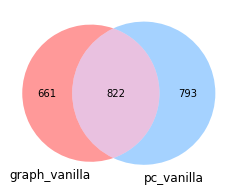

In [8]:
pipe_res, all_lams = load_all_pipeline_results(RDIR)
display(pipe_res.keys())
display(all_lams.keys())
compare_methods(pipe_res, ["graph_vanilla", "pc_vanilla"])

$\pi^\mathtt{B}$  $\pi^\mathtt{G}$  $\xi^\mathtt{G}$  \
Cell1                 3          0.010613          0.022753   
Cell2                 7          0.029973          0.022153   
Cell3                 7          0.026740          0.024046   
Cell4                 7          0.031416          0.018866   
Cell5                 4         -0.029628         -0.054783   

       $\omega^\mathtt{1}$  $\omega^\mathtt{2}$  
Cell1             0.682967             0.600050  
Cell2             0.768242             0.621814  
Cell3             0.781591             0.678568  
Cell4             0.768702             0.654502  
Cell5             0.137123             0.229735

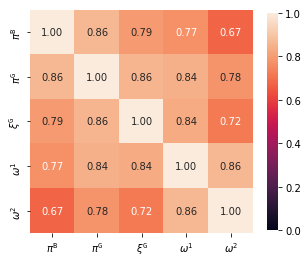

In [12]:
from plot_utils import plot_corr_mtx

# select and rename here
select_vars = {
    "smFISH": r"$\pi^\mathtt{B}$",
    "graph_vanilla_lam_init": r"$\pi^\mathtt{G}$",
#     "pc_vanilla_lam_init": r"$\pi^\mathtt{P}$",
    "graph_vanilla_lam_update": r"$\xi^\mathtt{G}$",
#     "pc_vanilla_lam_update": r"$\xi^\mathtt{P}$",
#     "unsup_graph": r"$\omega^\mathtt{G}$",
#     "unsup_pc": r"$\omega^\mathtt{P}$",
    "palantir": r"$\omega^\mathtt{1}$",
    "paga" : r"$\omega^\mathtt{2}$"
}
sub_df = lam_df[list(select_vars.keys())]
sub_df = sub_df.rename(index=str, columns=select_vars)
display(sub_df.head())
# save the lambdas to file
# sub_df.to_csv("~/lambdas.csv", index=False)
# fn = '/scratch/users/jjzhu/tmp_fig/hepa_hm.pdf'
fn = None
plot_corr_mtx(sub_df, fn=fn)

### Search for p-values of known genes

In [13]:
from main_methods import setup_cmp_df
from liver_info import get_known_liver_markers, get_marker_color_dict
from plot_utils import create_color_map, plot_full_pattern
from matplotlib.ticker import FormatStrFormatter
from plot_utils import update_boxplot_cols

def get_unique_rejection_df(res_dict, var_df):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
    df_list = []
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = pval_df.loc[pval_df[mets[i]] <= pval_thres[i]]
        sub_df = sub_df.loc[sub_df[mets[j]] > pval_thres[j]]
        sub_df["exclusive_rejection"] = mets[i]
        logger.info("Set selection: {}".format(sub_df.shape)) 
        sub_df = sub_df.set_index("gene_ids")
        sub_df = sub_df.sort_values([mets[i], mets[j]], ascending=[1, 0])
#         sub_df = sub_df.sort_values([mets[i], "std"], ascending=[1, 0])
        df_list.append(sub_df)
    df_comp = pd.concat(df_list, axis=0) # should never conflict
    df_dict = dict(zip(mets, df_list))
    return df_dict, df_comp

def parse_exlusive_genes():
    mets = list(res_dict.keys())
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        plt_genes = list(sub_df.loc[plt_idx]["gene_ids"])
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        if cat_avg:
            lam_in = rank_and_bin(lam_in, n_bins=9)                
        plot_gene_profile(lam_in, x_d[:, plt_idx], plt_genes, cat_avg=cat_avg)
        
def report_gene_info(report_genes):
    for gene in report_genes:
        if gene in unique_df.index:
            gene_info = unique_df.loc[gene]
            logger.info("{} only rejected by {}".format(gene, gene_info["exclusive_rejection"]))
    display(pval_df[pval_df["gene_ids"].isin(report_genes)])
    

def plot_gene_expr_comp(lam_df, x_d, genes, methods, horizontal=False, fn=None):
    fontsize=16
    report_gene_info(genes)
    labels = list(lam_df["smFISH"])
    if len(genes) == 1 and len(methods) == 1:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
    else:
        if horizontal:
            fig, axes = plt.subplots(len(methods), len(genes), 
                                 figsize=(2.3*len(genes), 2*len(methods)))
        else:
            fig, axes = plt.subplots(len(genes), len(methods), 
                                 figsize=(1.65*len(methods),2.05*len(genes)),
                                 sharex="col", sharey="row")
    
    for i, gene in enumerate(genes):
        gid = var_df.index.get_loc(gene)
        for j, method in enumerate(methods):
            if len(genes) == 1 and len(methods) == 1:
                ax = axes
                add_cbar = True
            else:
                add_cbar = False
                if len(genes) == 1:
                    ax = axes[j]
                elif len(methods) == 1:
                    ax = axes[i]
                else:        
                    if horizontal:
                        ax = axes[j, i]
                    else:
                        ax = axes[i, j]
            order_only = (method != "smFISH")
            plot_full_pattern(ax, lam_df[method], x_d[:,gid], 
                              order_only=order_only,
                              add_color_bar=add_cbar, labels=labels)    
            if horizontal:
                ax.set_xlabel(None)
                fig.subplots_adjust(hspace=0.5, wspace=0.42)
                ax.set_ylabel(gene, labelpad=0, fontsize=fontsize)
                if len(methods) > 1:
                    ax.set_title(select_vars[method])    
            else:
                if j == 0:
                    ax.set_ylabel(gene, fontsize=fontsize)
                if i == (len(genes) -1):
                    ax.set_xlabel(select_vars[method], fontsize=fontsize)
                fig.subplots_adjust(hspace=0, wspace=0)
            
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize-1)
            if method == "smFISH":
                xticks = [1,3, 5, 7, 9]
            else:
                xticks = [0, 1000]
            if gene == "Malat1":
                ax.set_ylim(-0.5, 3)
                ax.set_yticks(ticks=[0, 1, 2])  
            ax.set_xticks(ticks=xticks)    
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True, dpi=150) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()
    

def contrast_methods_gene(res_dict, var_df, x_d, lam_in=None, disp_genes=8):
    pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(res_dict)
    var_df = var_df.reset_index(drop=True)
    pval_df = pd.concat([var_df, pval_df], axis=1)
    logger.info("Merged df: {}".format(pval_df.shape))    
    union_idx = set.union(*cmp_sets)
    df_comp = get_unique_rejection_df(res_dict, var_df)
    use_lam = (lam_in is not None)
    for i in range(2):
        j = 1 * (i == 0)
        sub_df = df_comp.sort_values([mets[i], mets[j]], ascending=[1, 0])
        sub_df = sub_df.head(disp_genes)
        display(sub_df)
        plt_idx = list(sub_df.index)
        fig, axes = plt.subplots(1, len(plt_idx), figsize=(len(plt_idx)*3, 3))
        if not use_lam:
            lam_in = res_dict[mets[i]]["lam_init"]
        for i_g, g_idx in enumerate(plt_idx):
            ax = axes[i_g]
            ax.scatter(lam_in, x_d[:, g_idx], s=5)
            ax.set_title(sub_df.loc[g_idx]["gene_ids"])
        plt.show()
        
def plot_contrast_rejections(res_dict, var_df, plain=False, fn=None):
    fontsize=15
    my_pal = {"pc_vanilla": "red", "graph_vanilla":"blue"}
    _, df_comp = get_unique_rejection_df(res_dict, var_df)
    plt_vars = ['sparsity', 'cv']
    fig, axes = plt.subplots(1, len(plt_vars), figsize=(len(plt_vars)*2.7, 3))
    for i_plt, var in enumerate(plt_vars):
        ax = axes[i_plt]
        

        sns.boxplot(x="exclusive_rejection", y=var, 
                    data=df_comp, ax=ax, 
#                     order=["graph_vanilla", "pc_vanilla"],
                    palette="Set1",
                    width=0.5, fliersize=1)
        ax.set_title(var)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        update_boxplot_cols(ax)
        if plain:
            ax.set_title(None)
            ax.set_xticks([])
            ax.tick_params(axis='both', which='major', pad=2, labelsize=fontsize)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        logger.info("Saved figure to: {}".format(fn))
    plt.show()

gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
904       Alb     1415  6.190163  0.610225  1415      0.0001         0.0001
1191      Asl     1397  2.707551  0.570133  1397      0.0001         0.0001
1200     Ass1     1411  3.164296  0.588850  1411      0.0001         0.0001
2350   Cyp2e1     1221  3.086100  2.132811  1221      0.0001         0.0001
2351   Cyp2f2     1235  2.269190  1.415569  1235      0.0001         0.0001
3496     Glul      523  0.347392  0.661617   523      0.0001         0.0001

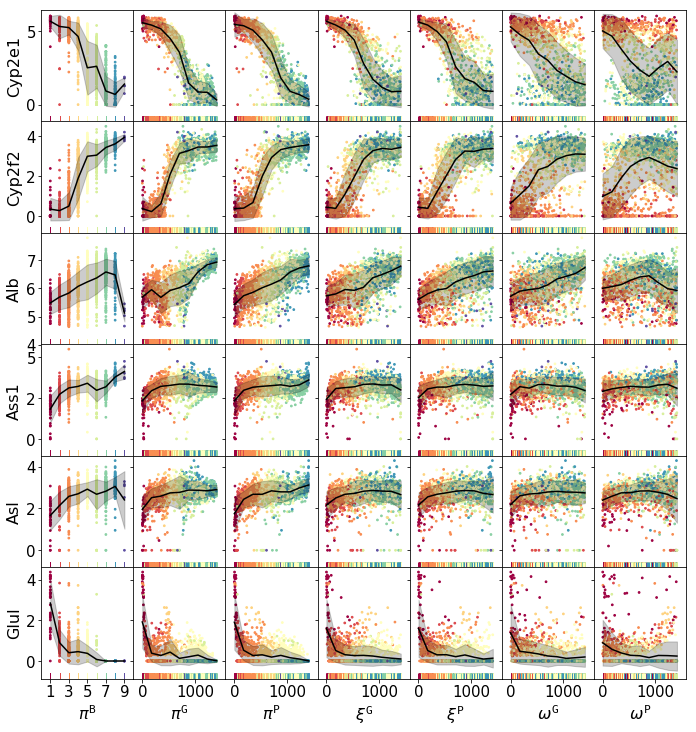

In [19]:
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods)

[feat_viz INFO] Brap only rejected by pc_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
1525     Brap     1189  1.103937  0.646323  1189      0.0001       0.018298

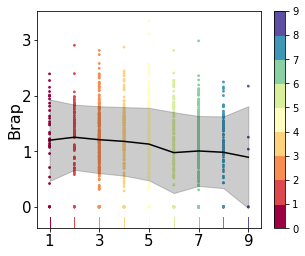

In [15]:
# example of a single gene and a single method
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True)

gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
904       Alb     1415  6.190163  0.610225  1415      0.0001         0.0001
1191      Asl     1397  2.707551  0.570133  1397      0.0001         0.0001
1200     Ass1     1411  3.164296  0.588850  1411      0.0001         0.0001
2350   Cyp2e1     1221  3.086100  2.132811  1221      0.0001         0.0001
2351   Cyp2f2     1235  2.269190  1.415569  1235      0.0001         0.0001
3496     Glul      523  0.347392  0.661617   523      0.0001         0.0001

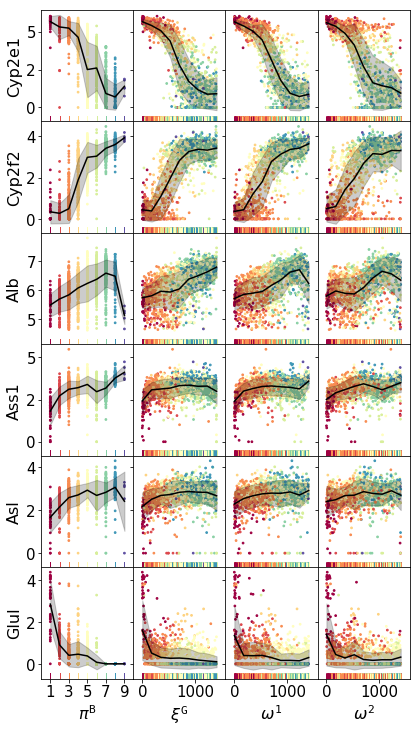

In [18]:
methods = ["smFISH",
#            "graph_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "palantir",
           "paga"]
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods)

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
2371   Cyp8b1     1315  1.913578  0.753823  1315    0.000100         0.0001
3764     Hamp     1327  2.937353  1.240587  1327    0.000500         0.0001
3765    Hamp2     1158  1.595090  1.069451  1158    0.000100         0.0001
4044   Igfbp2     1257  1.622701  0.830093  1257    0.033297         0.0001
5043     Mup3     1366  2.975959  1.237950  1366    0.000100         0.0001

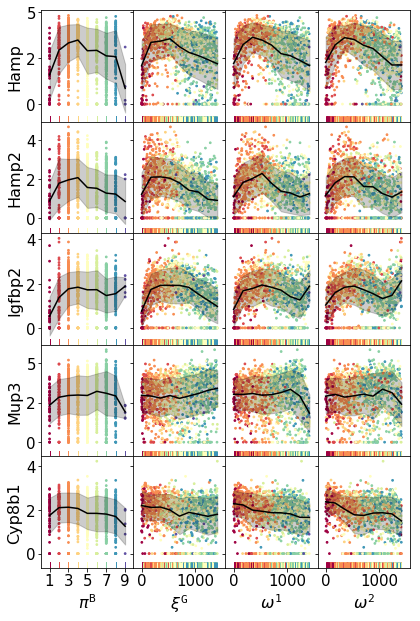

In [19]:
plot_gene_expr_comp(lam_df, x_d, report_genes, methods)

[feat_viz INFO] Phf3 only rejected by pc_vanilla
[feat_viz INFO] Pias4;PIAS-gamma only rejected by pc_vanilla
[feat_viz INFO] Serpine2 only rejected by pc_vanilla
[feat_viz INFO] Mylk;Mlyk only rejected by pc_vanilla
[feat_viz INFO] Acyp1 only rejected by pc_vanilla
[feat_viz INFO] Dnaja4 only rejected by pc_vanilla
[feat_viz INFO] Snhg6 only rejected by pc_vanilla
[feat_viz INFO] Aldh1a7 only rejected by pc_vanilla


gene_ids  n_cells      mean       std  npc  pc_vanilla  \
781              Acyp1      371  0.187429  0.366070  371      0.0001   
908            Aldh1a7      716  0.439747  0.516800  716      0.0001   
2627            Dnaja4       55  0.021674  0.119090   55      0.0001   
5072         Mylk;Mlyk      426  0.226912  0.418408  426      0.0001   
5761              Phf3      582  0.331940  0.470883  582      0.0001   
5785  Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001   
6967          Serpine2      189  0.096100  0.278162  189      0.0001   
7296             Snhg6      616  0.353233  0.471623  616      0.0001   

      graph_vanilla  
781        0.412859  
908        0.337766  
2627       0.401760  
5072       0.598340  
5761       0.838516  
5785       0.692231  
6967       0.623338  
7296       0.338466

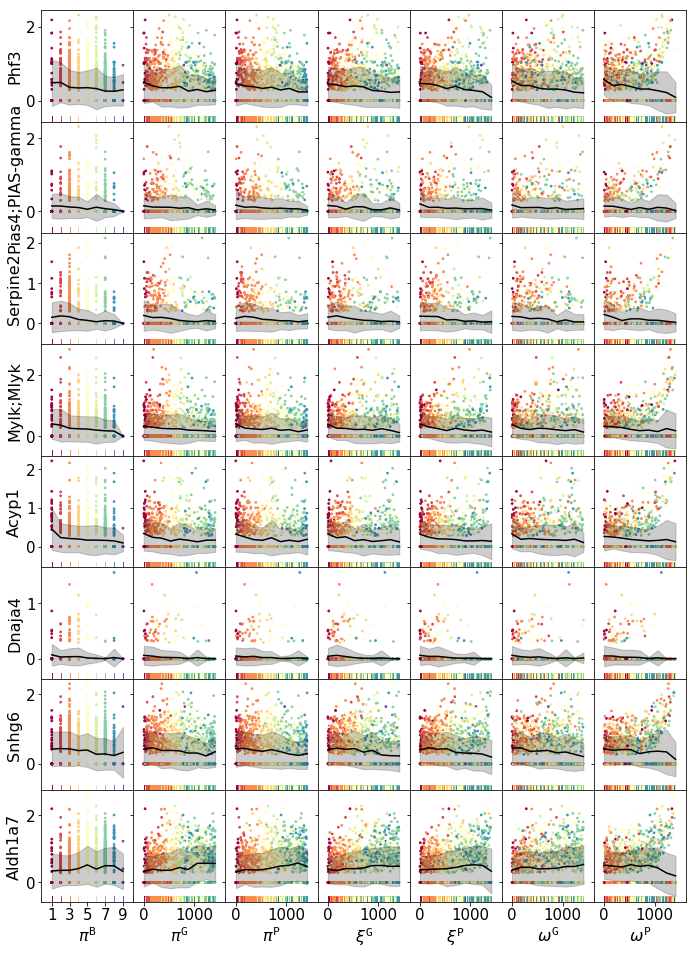

In [23]:
plot_gene_expr_comp(lam_df, x_d, unique_glist["pc_vanilla"][:8], methods)

[feat_viz INFO] Fgl1 only rejected by graph_vanilla
[feat_viz INFO] Ttpa only rejected by graph_vanilla
[feat_viz INFO] Mat1a only rejected by graph_vanilla
[feat_viz INFO] Ces1e only rejected by graph_vanilla
[feat_viz INFO] Ptplad1 only rejected by graph_vanilla
[feat_viz INFO] Hist1h1b only rejected by graph_vanilla
[feat_viz INFO] Aplp2 only rejected by graph_vanilla
[feat_viz INFO] C4bp only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc  pc_vanilla  graph_vanilla
1045     Aplp2     1154  1.118560  0.676803  1154    0.866513         0.0001
1604      C4bp      858  0.712044  0.701095   858    0.861914         0.0001
1915     Ces1e     1005  0.789574  0.623091  1005    0.902010         0.0001
3252      Fgl1     1180  1.262376  0.716935  1180    0.985501         0.0001
3855  Hist1h1b       29  0.021064  0.164727    29    0.867813         0.0001
4653     Mat1a     1414  3.928493  0.370627  1414    0.914909         0.0001
6238   Ptplad1      656  0.384490  0.491875   656    0.868713         0.0001
8138      Ttpa      607  0.350444  0.494714   607    0.917508         0.0001

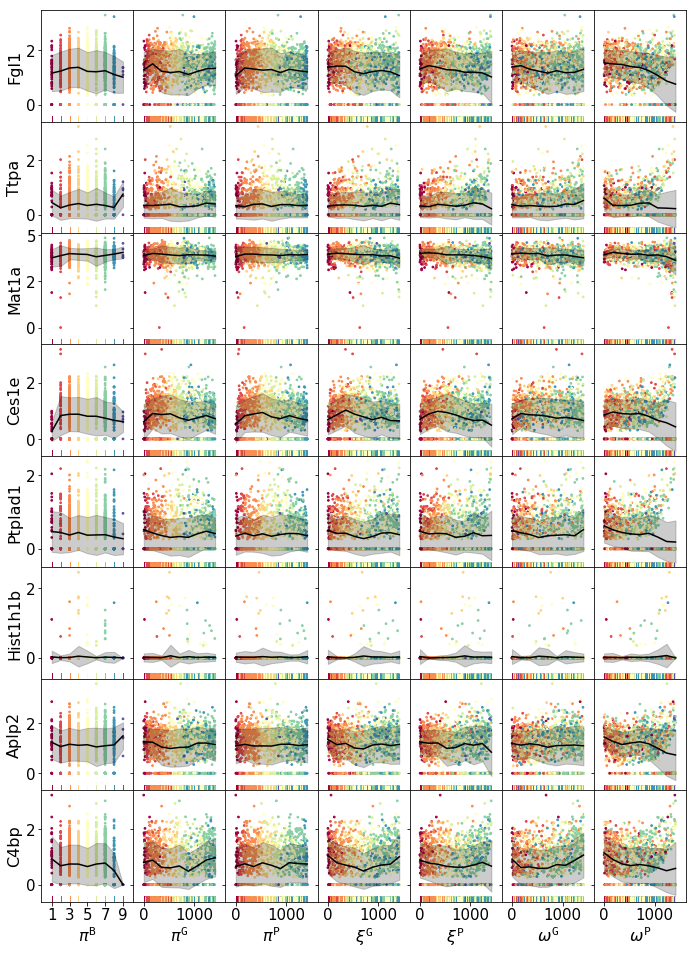

In [24]:
plot_gene_expr_comp(lam_df, x_d, unique_glist["graph_vanilla"][:8], methods)

## Save figures to file

In [38]:
FDIR = "/share/PI/sabatti/feat_viz/main_figs"

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_heatmap.pdf


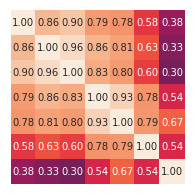

In [39]:
fn = os.path.join(FDIR, "real_data_heatmap.pdf")
plot_corr_mtx(sub_df, plain=True, fn=fn)

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 10)
[feat_viz INFO] Set selection: (661, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_box_uniq.pdf


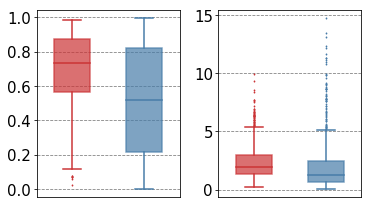

In [47]:
fn = os.path.join(FDIR, "real_data_box_uniq.pdf")
plot_contrast_rejections(cmp_methods, var_df, plain=True, fn=fn)

[feat_viz INFO] Brap only rejected by pc_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1525     Brap     1189  1.103937  0.646323  1189  0.585471  0.159717   

      pc_vanilla  graph_vanilla  
1525      0.0001       0.018298

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_scalebar.pdf


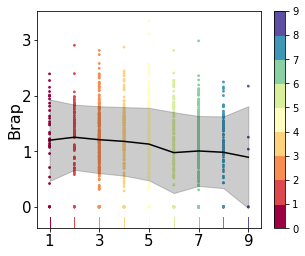

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_lm.pdf


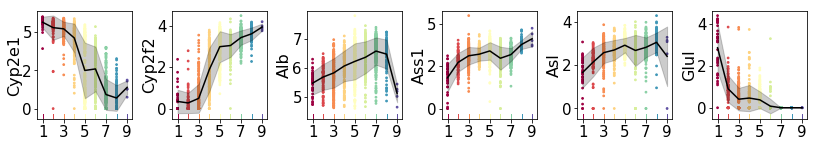

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   

      pc_vanilla  graph_vanilla  
3765    0.000100         0.0001  
4044    0.033297         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_val.pdf


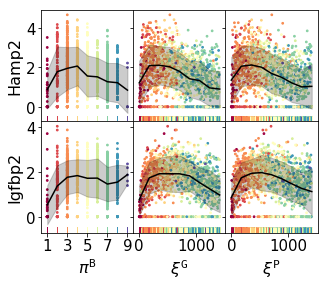

[feat_viz INFO] C4bp only rejected by graph_vanilla
[feat_viz INFO] Phf3 only rejected by pc_vanilla


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
1604     C4bp      858  0.712044  0.701095  858  0.984623  0.393640   
5761     Phf3      582  0.331940  0.470883  582  1.418580  0.588693   

      pc_vanilla  graph_vanilla  
1604    0.861914       0.000100  
5761    0.000100       0.838516

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_uniq.pdf


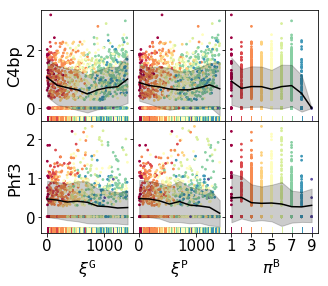

In [49]:
fn = os.path.join(FDIR, "real_data_scalebar.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Brap"], ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_lm.pdf")
plot_gene_expr_comp(lam_df, x_d, lm_genes, ["smFISH"], horizontal=True, fn=fn)
fn = os.path.join(FDIR, "real_data_genes_val.pdf")
plot_gene_expr_comp(lam_df, x_d, ["Hamp2", "Igfbp2"], ["smFISH", "graph_vanilla_lam_update", "pc_vanilla_lam_update"], fn=fn)
fn = os.path.join(FDIR, "real_data_genes_uniq.pdf")
plot_gene_expr_comp(lam_df, x_d, ["C4bp", "Phf3"], ["graph_vanilla_lam_update", "pc_vanilla_lam_update","smFISH"],fn=fn)

gene_ids  n_cells      mean       std   npc        cv  sparsity  \
904       Alb     1415  6.190163  0.610225  1415  0.098580  0.000000   
1191      Asl     1397  2.707551  0.570133  1397  0.210571  0.012721   
1200     Ass1     1411  3.164296  0.588850  1411  0.186092  0.002827   
2350   Cyp2e1     1221  3.086100  2.132811  1221  0.691102  0.137102   
2351   Cyp2f2     1235  2.269190  1.415569  1235  0.623821  0.127208   
3496     Glul      523  0.347392  0.661617   523  1.904525  0.630389   

      pc_vanilla  graph_vanilla  
904       0.0001         0.0001  
1191      0.0001         0.0001  
1200      0.0001         0.0001  
2350      0.0001         0.0001  
2351      0.0001         0.0001  
3496      0.0001         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_lm.png


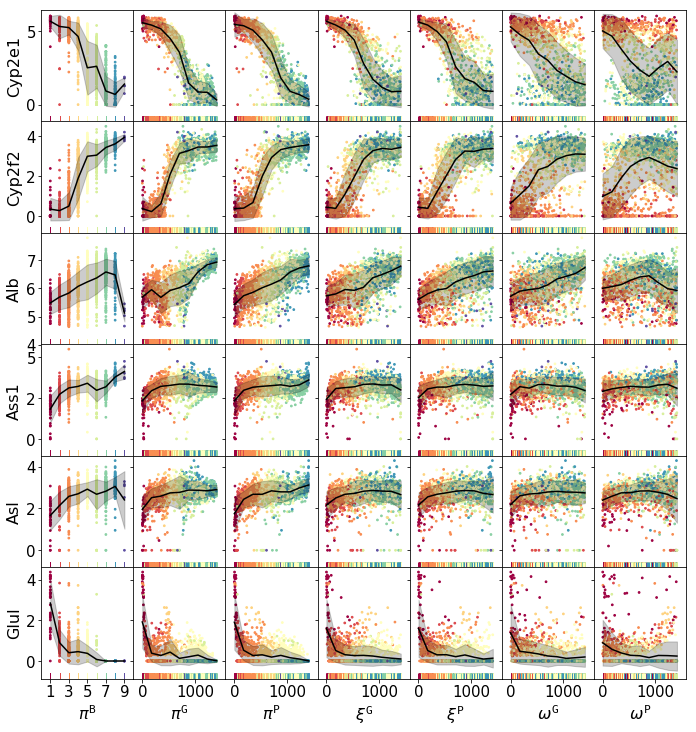

In [43]:
plt_id = "lm"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, lm_genes, methods, fn=fn)

[feat_viz INFO] Igfbp2 only rejected by graph_vanilla


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
2371   Cyp8b1     1315  1.913578  0.753823  1315  0.393934  0.070671   
3764     Hamp     1327  2.937353  1.240587  1327  0.422349  0.062191   
3765    Hamp2     1158  1.595090  1.069451  1158  0.670465  0.181625   
4044   Igfbp2     1257  1.622701  0.830093  1257  0.511550  0.111661   
5043     Mup3     1366  2.975959  1.237950  1366  0.415984  0.034629   

      pc_vanilla  graph_vanilla  
2371    0.000100         0.0001  
3764    0.000500         0.0001  
3765    0.000100         0.0001  
4044    0.033297         0.0001  
5043    0.000100         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_report.png


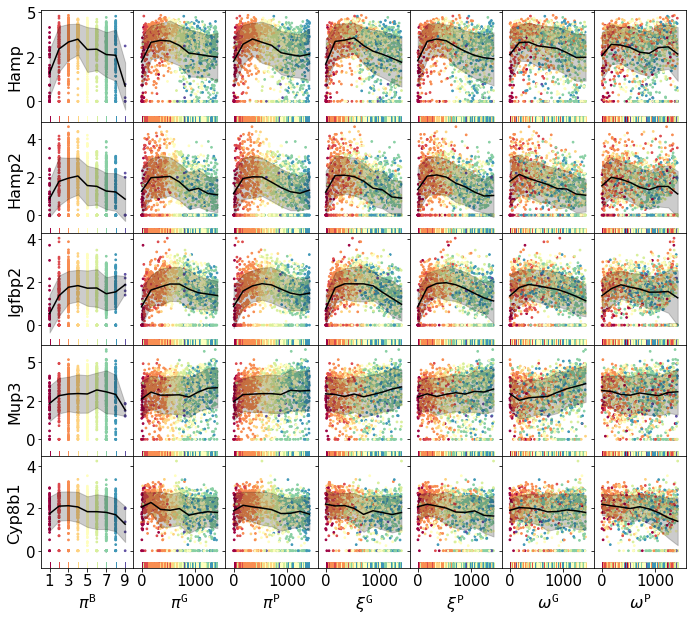

In [44]:
plt_id = "report"
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, report_genes, methods, fn=fn)

[feat_viz INFO] Fgl1 only rejected by graph_vanilla
[feat_viz INFO] Ttpa only rejected by graph_vanilla
[feat_viz INFO] Mat1a only rejected by graph_vanilla
[feat_viz INFO] Ces1e only rejected by graph_vanilla
[feat_viz INFO] Ptplad1 only rejected by graph_vanilla
[feat_viz INFO] Hist1h1b only rejected by graph_vanilla
[feat_viz INFO] Aplp2 only rejected by graph_vanilla
[feat_viz INFO] C4bp only rejected by graph_vanilla


['Fgl1', 'Ttpa', 'Mat1a', 'Ces1e', 'Ptplad1', 'Hist1h1b', 'Aplp2', 'C4bp']


gene_ids  n_cells      mean       std   npc        cv  sparsity  \
1045     Aplp2     1154  1.118560  0.676803  1154  0.605067  0.184452   
1604      C4bp      858  0.712044  0.701095   858  0.984623  0.393640   
1915     Ces1e     1005  0.789574  0.623091  1005  0.789148  0.289753   
3252      Fgl1     1180  1.262376  0.716935  1180  0.567925  0.166078   
3855  Hist1h1b       29  0.021064  0.164727    29  7.820231  0.979505   
4653     Mat1a     1414  3.928493  0.370627  1414  0.094343  0.000707   
6238   Ptplad1      656  0.384490  0.491875   656  1.279292  0.536396   
8138      Ttpa      607  0.350444  0.494714   607  1.411676  0.571025   

      pc_vanilla  graph_vanilla  
1045    0.866513         0.0001  
1604    0.861914         0.0001  
1915    0.902010         0.0001  
3252    0.985501         0.0001  
3855    0.867813         0.0001  
4653    0.914909         0.0001  
6238    0.868713         0.0001  
8138    0.917508         0.0001

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_graph.png


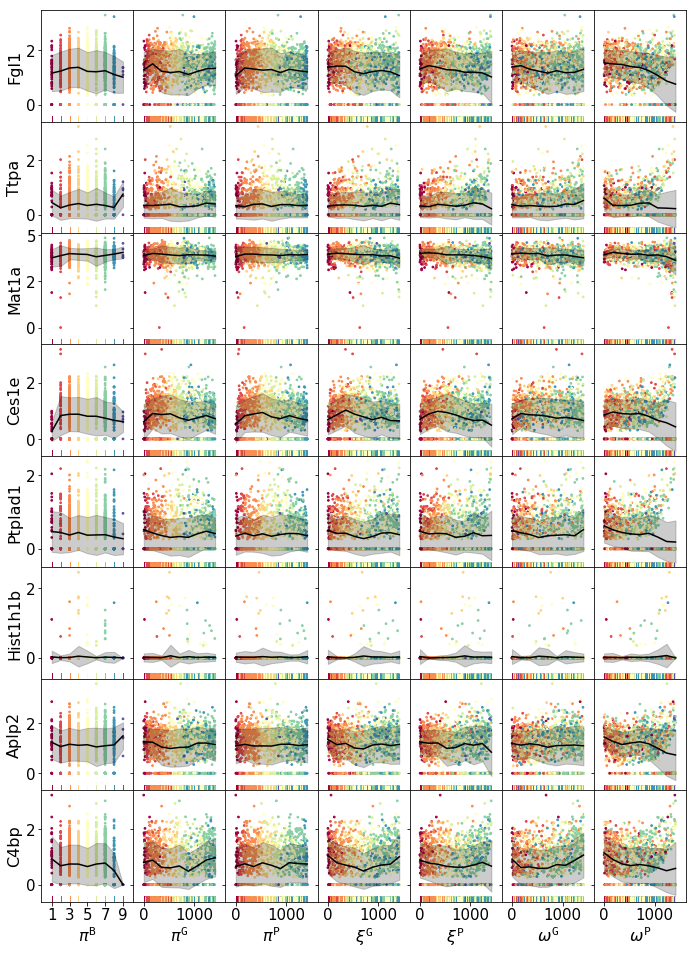

In [45]:
plt_id = "graph"
genes = unique_glist["graph_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)

[feat_viz INFO] Phf3 only rejected by pc_vanilla
[feat_viz INFO] Pias4;PIAS-gamma only rejected by pc_vanilla
[feat_viz INFO] Serpine2 only rejected by pc_vanilla
[feat_viz INFO] Mylk;Mlyk only rejected by pc_vanilla
[feat_viz INFO] Acyp1 only rejected by pc_vanilla
[feat_viz INFO] Dnaja4 only rejected by pc_vanilla
[feat_viz INFO] Snhg6 only rejected by pc_vanilla
[feat_viz INFO] Aldh1a7 only rejected by pc_vanilla


['Phf3', 'Pias4;PIAS-gamma', 'Serpine2', 'Mylk;Mlyk', 'Acyp1', 'Dnaja4', 'Snhg6', 'Aldh1a7']


gene_ids  n_cells      mean       std  npc        cv  sparsity  \
781              Acyp1      371  0.187429  0.366070  371  1.953116  0.737809   
908            Aldh1a7      716  0.439747  0.516800  716  1.175222  0.493993   
2627            Dnaja4       55  0.021674  0.119090   55  5.494523  0.961131   
5072         Mylk;Mlyk      426  0.226912  0.418408  426  1.843921  0.698940   
5761              Phf3      582  0.331940  0.470883  582  1.418580  0.588693   
5785  Pias4;PIAS-gamma      174  0.090250  0.276415  174  3.062762  0.877032   
6967          Serpine2      189  0.096100  0.278162  189  2.894513  0.866431   
7296             Snhg6      616  0.353233  0.471623  616  1.335159  0.564664   

      pc_vanilla  graph_vanilla  
781       0.0001       0.412859  
908       0.0001       0.337766  
2627      0.0001       0.401760  
5072      0.0001       0.598340  
5761      0.0001       0.838516  
5785      0.0001       0.692231  
6967      0.0001       0.623338  
7296      0.0001       0.338466

[feat_viz INFO] Saved figure to: /share/PI/sabatti/feat_viz/main_figs/real_data_genes_all_pca.png


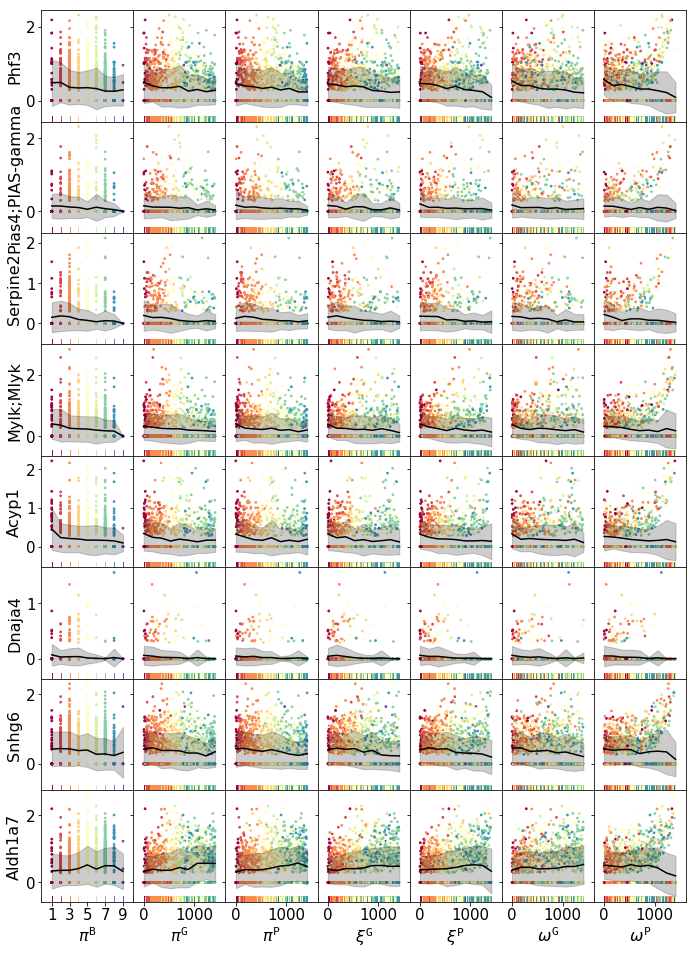

In [46]:
plt_id = "pca"
genes = unique_glist["pc_vanilla"][:8]
print(genes)
fn = os.path.join(FDIR, "real_data_genes_all_{}.png".format(plt_id))
plot_gene_expr_comp(lam_df, x_d, genes, methods, fn=fn)

# Comparison with PC methods

### Run all the prescribed methods and save to file

[feat_viz INFO] Saved figure to: /scratch/users/jjzhu/tmp_fig/hepa_hm.pdf


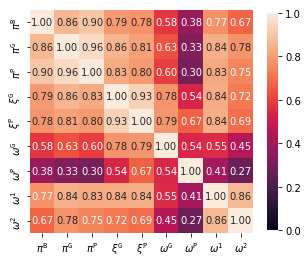

In [10]:
# previous comparisons

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 8)
[feat_viz INFO] Set selection: (661, 8)


n_cells      mean       std  npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                        
Phf3                  582  0.331940  0.470883  582      0.0001       0.838516   
Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001       0.692231   
Serpine2              189  0.096100  0.278162  189      0.0001       0.623338   
Mylk;Mlyk             426  0.226912  0.418408  426      0.0001       0.598340   
Acyp1                 371  0.187429  0.366070  371      0.0001       0.412859   
Dnaja4                 55  0.021674  0.119090   55      0.0001       0.401760   
Snhg6                 616  0.353233  0.471623  616      0.0001       0.338466   
Aldh1a7               716  0.439747  0.516800  716      0.0001       0.337766   
Chkb                  572  0.327438  0.473519  572      0.0001       0.300770   
Cela1                 399  0.205881  0.381610  399      0.0001       0.300670   

                 exclusive_rejection  
gene_ids                              
Phf3                      pc_vanilla  
Pias4;PIAS-gamma          pc_vanilla  
Serpine2                  pc_vanilla  
Mylk;Mlyk                 pc_vanilla  
Acyp1                     pc_vanilla  
Dnaja4                    pc_vanilla  
Snhg6                     pc_vanilla  
Aldh1a7                   pc_vanilla  
Chkb                      pc_vanilla  
Cela1                     pc_vanilla

n_cells      mean       std   npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                 
Fgl1         1180  1.262376  0.716935  1180    0.985501         0.0001   
Ttpa          607  0.350444  0.494714   607    0.917508         0.0001   
Mat1a        1414  3.928493  0.370627  1414    0.914909         0.0001   
Ces1e        1005  0.789574  0.623091  1005    0.902010         0.0001   
Ptplad1       656  0.384490  0.491875   656    0.868713         0.0001   
Hist1h1b       29  0.021064  0.164727    29    0.867813         0.0001   
Aplp2        1154  1.118560  0.676803  1154    0.866513         0.0001   
C4bp          858  0.712044  0.701095   858    0.861914         0.0001   
Lpgat1       1043  0.821111  0.625455  1043    0.845015         0.0001   
Atp5e        1361  1.968188  0.639012  1361    0.822418         0.0001   

         exclusive_rejection  
gene_ids                      
Fgl1           graph_vanilla  
Ttpa           graph_vanilla  
Mat1a          graph_vanilla  
Ces1e          graph_vanilla  
Ptplad1        graph_vanilla  
Hist1h1b       graph_vanilla  
Aplp2          graph_vanilla  
C4bp           graph_vanilla  
Lpgat1         graph_vanilla  
Atp5e          graph_vanilla

n_cells      mean       std  npc  pc_vanilla  graph_vanilla  \
gene_ids                                                                        
Phf3                  582  0.331940  0.470883  582      0.0001       0.838516   
Pias4;PIAS-gamma      174  0.090250  0.276415  174      0.0001       0.692231   
Serpine2              189  0.096100  0.278162  189      0.0001       0.623338   
Mylk;Mlyk             426  0.226912  0.418408  426      0.0001       0.598340   
Acyp1                 371  0.187429  0.366070  371      0.0001       0.412859   

                 exclusive_rejection  
gene_ids                              
Phf3                      pc_vanilla  
Pias4;PIAS-gamma          pc_vanilla  
Serpine2                  pc_vanilla  
Mylk;Mlyk                 pc_vanilla  
Acyp1                     pc_vanilla

gene_ids  n_cells      mean       std  npc  \
0610007C21Rik;Apr3      0610007C21Rik;Apr3      770  0.487967  0.527124  770   
0610007L01Rik                0610007L01Rik      761  0.455494  0.506628  761   
0610007P08Rik;Rad26l  0610007P08Rik;Rad26l       65  0.030682  0.159816   65   
0610007P14Rik                0610007P14Rik      749  0.456374  0.518156  749   
0610007P22Rik                0610007P22Rik       35  0.015438  0.107326   35   

                            cv  sparsity  
0610007C21Rik;Apr3    1.080244  0.455830  
0610007L01Rik         1.112262  0.462191  
0610007P08Rik;Rad26l  5.208739  0.954064  
0610007P14Rik         1.135376  0.470671  
0610007P22Rik         6.952005  0.975265

[feat_viz INFO] pc_vanilla threshold: 0.0089
[feat_viz INFO] graph_vanilla threshold: 0.0083
[feat_viz INFO] Set selection: (793, 10)
[feat_viz INFO] Set selection: (661, 10)
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.


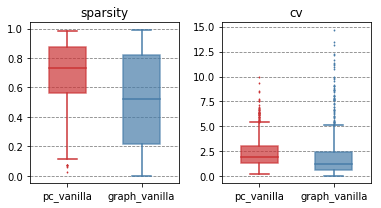

In [14]:
methods = ["smFISH", 
           "graph_vanilla_lam_init", 
           "pc_vanilla_lam_init", 
           "graph_vanilla_lam_update", 
           "pc_vanilla_lam_update",
           "unsup_graph",
           "unsup_pc"]


cmp_methods = {key: pipe_res[key] for key in ["pc_vanilla", "graph_vanilla"]}
pval_df, pval_thres, cmp_sets, mets = setup_cmp_df(cmp_methods)
pval_df = pd.concat([var_df.reset_index(drop=True), pval_df], axis=1)
pval_df.head()
lm_genes = get_known_liver_markers()["zonation"]
report_genes = ["Hamp", "Hamp2", "Igfbp2", "Mup3", "Cyp8b1"]
unique_dict, unique_df = get_unique_rejection_df(cmp_methods, var_df)
unique_glist = {}
top_k = 10
for key in cmp_methods:
    unique_glist[key] = list(unique_dict[key].index[:top_k])
    display(unique_dict[key].head(top_k))
display(unique_df.head())

# plot box plots
var_df["cv"] = var_df["std"] / var_df["mean"]
var_df["sparsity"] = 1 - (var_df["n_cells"]/ x_d.shape[0])
display(var_df.head())
plot_contrast_rejections(cmp_methods, var_df)
